In [ ]:
# !pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 36.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras_cv
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt

keras.utils.set_random_seed(31)

### Create the MobileNet Model

In [3]:
def depthwise_seperable_module(x, filter_size:int, depthwise_kernel:int=3, pointwise_kernel:int=1, stride:int=1):
    # depthwise block
    x = layers.DepthwiseConv2D(kernel_size=depthwise_kernel, strides=stride, padding='same',)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # pointwise block
    x = layers.Conv2D(filter_size, kernel_size=pointwise_kernel, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [4]:
def build_mobilenet(input_shape:tuple=(32, 32, 3), num_classes:int=10) -> tf.keras.Model:
    inputs = layers.Input(shape=input_shape)

    # initial convolution
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 64 filter depthwise seperable blocks
    x = depthwise_seperable_module(x, filter_size=64)

    # 128 filter depthwise seperable blocks
    x = depthwise_seperable_module(x, filter_size=128, stride=2)
    x = depthwise_seperable_module(x, filter_size=128)

    # 256 filter depthwise seperable blocks
    x = depthwise_seperable_module(x, filter_size=256, stride=2)
    x = depthwise_seperable_module(x, filter_size=256)

    # 512 filter depthwise seperable blocks
    x = depthwise_seperable_module(x, filter_size=512, stride=2)
    x = depthwise_seperable_module(x, filter_size=512)
    x = depthwise_seperable_module(x, filter_size=512)
    x = depthwise_seperable_module(x, filter_size=512)

    # glob. avg. pooling and output
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='mobilenet_cifar10')

    return model

### Prepare the Dataset

In [5]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [6]:
def prepare_dataset(dataset, shuffle:bool=True, augment:bool=False):

    rand_augment = keras_cv.layers.RandAugment(
      value_range=(0, 255), augmentations_per_image=3, magnitude=0.2
    )

    if shuffle:
      dataset = dataset.shuffle(BATCH_SIZE * 1000)

    dataset = dataset.batch(BATCH_SIZE)

    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: (rand_augment(x), y),  # RandAugment can process it
            num_parallel_calls=AUTO,
        )

    dataset = dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=AUTO,
    )

    return dataset.prefetch(AUTO)

In [7]:
def fetch_and_augment_cifar10() -> tuple:
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    # partition the train data to obtain a val data
    num_samples = x_train.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices, )     # shuffle to avoid bias

    x_train, y_train = x_train[indices], y_train[indices]

    val_size = int(0.1 * num_samples)

    # 45000 train and 5000 val datapoints
    x_val, y_val = x_train[:val_size], y_train[:val_size]
    x_train, y_train = x_train[val_size:], y_train[val_size:]


    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test,  y_test))

    train_ds_original = prepare_dataset(train_ds)
    train_ds = prepare_dataset(train_ds, shuffle=True, augment=True)
    val_ds = prepare_dataset(val_ds)
    test_ds = prepare_dataset(test_ds, shuffle=False)

    return (train_ds, val_ds, test_ds, y_test, train_ds_original)

In [8]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = 32

train_ds, val_ds, test_ds, y_test, train_ds_original = fetch_and_augment_cifar10()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


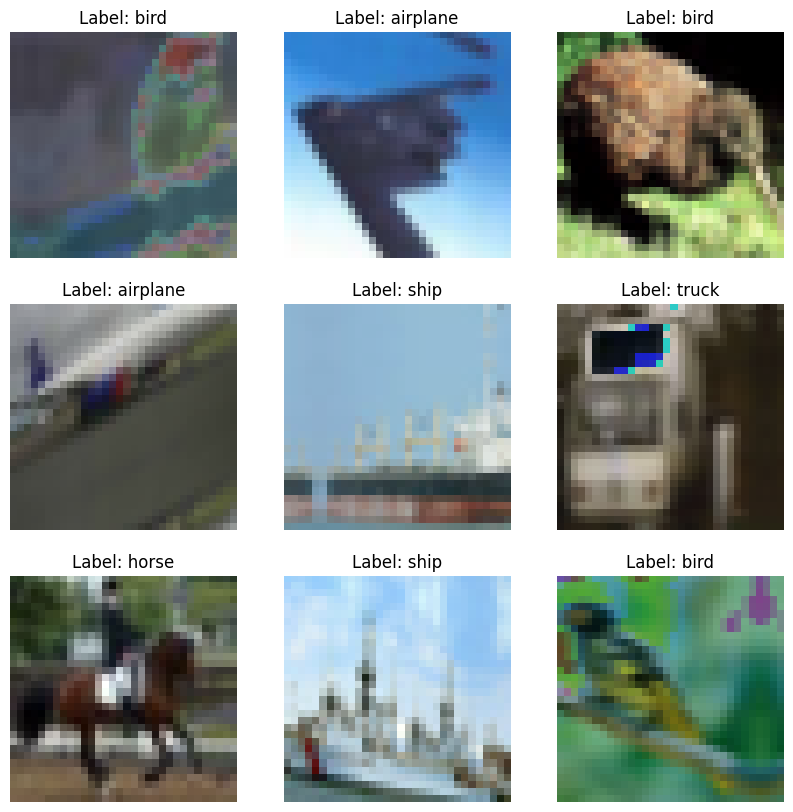

In [9]:
sample_images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {classes[int(labels[i])]}")
    plt.axis("off")

### Train the Model

In [11]:
def train_mobilenet(train_ds:tf.data.Dataset, val_ds:tf.data.Dataset) -> tuple:
    # build model
    model = build_mobilenet()

    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'mobilenet_cifar10.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    callbacks = [
        early_stopping,
        lr_scheduler,
        model_checkpoint
    ]

    # train the model
    history = model.fit(
        train_ds,
        epochs=150,
        validation_data=val_ds,
        callbacks=callbacks
    )

    return model, history

In [12]:
model, history = train_mobilenet(train_ds, val_ds)

Epoch 1/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2694 - loss: 1.9798
Epoch 1: val_accuracy improved from -inf to 0.44540, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 93s 46ms/step - accuracy: 0.2695 - loss: 1.9797 - val_accuracy: 0.4454 - val_loss: 1.5740 - learning_rate: 0.0010
Epoch 2/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4622 - loss: 1.4898
Epoch 2: val_accuracy improved from 0.44540 to 0.60040, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.4622 - loss: 1.4897 - val_accuracy: 0.6004 - val_loss: 1.1605 - learning_rate: 0.0010
Epoch 3/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5620 - loss: 1.2330
Epoch 3: val_accuracy improved from 0.60040 to 0.66180, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.5620 - loss: 1.2329 - val_accuracy: 0.6618 - val_loss: 0.9955 - learning_rate: 0.0010
Epoch 4/150
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6156 - loss: 1.0888
Epoch 4: val_accuracy improved from 0.66180 to 0.67280, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.6156 - loss: 1.0887 - val_accuracy: 0.6728 - val_loss: 0.9818 - learning_rate: 0.0010
Epoch 5/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6519 - loss: 0.9934
Epoch 5: val_accuracy improved from 0.67280 to 0.69680, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.6520 - loss: 0.9933 - val_accuracy: 0.6968 - val_loss: 0.9422 - learning_rate: 0.0010
Epoch 6/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6806 - loss: 0.9147
Epoch 6: val_accuracy improved from 0.69680 to 0.74940, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.6806 - loss: 0.9146 - val_accuracy: 0.7494 - val_loss: 0.7196 - learning_rate: 0.0010
Epoch 7/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6986 - loss: 0.8582
Epoch 7: val_accuracy improved from 0.74940 to 0.76700, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.6986 - loss: 0.8582 - val_accuracy: 0.7670 - val_loss: 0.6766 - learning_rate: 0.0010
Epoch 8/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7210 - loss: 0.8060
Epoch 8: val_accuracy improved from 0.76700 to 0.80000, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.7210 - loss: 0.8060 - val_accuracy: 0.8000 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 9/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7341 - loss: 0.7665
Epoch 9: val_accuracy improved from 0.80000 to 0.80820, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.7341 - loss: 0.7665 - val_accuracy: 0.8082 - val_loss: 0.5775 - learning_rate: 0.0010
Epoch 10/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7456 - loss: 0.7279
Epoch 10: val_accuracy improved from 0.80820 to 0.81540, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.7456 - loss: 0.7279 - val_accuracy: 0.8154 - val_loss: 0.5472 - learning_rate: 0.0010
Epoch 11/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7614 - loss: 0.6810
Epoch 11: val_accuracy improved from 0.81540 to 0.82200, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.7614 - loss: 0.6810 - val_accuracy: 0.8220 - val_loss: 0.5124 - learning_rate: 0.0010
Epoch 12/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7663 - loss: 0.6798
Epoch 12: val_accuracy did not improve from 0.82200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.7663 - loss: 0.6798 - val_accuracy: 0.8062 - val_loss: 0.5677 - learning_rate: 0.0010
Epoch 13/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7709 - loss: 0.6571
Epoch 13: val_accuracy improved from 0.82200 to 0.82220, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.7709 - loss: 0.6571 - val_accuracy: 0.8222 - val_loss: 0.5230 - learning_rate: 0.0010
Epoch 14/150
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7876 - loss: 0.6210
Epoch 14: val_accuracy improved from 0.82220 to 0.84640, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.7876 - loss: 0.6211 - val_accuracy: 0.8464 - val_loss: 0.4513 - learning_rate: 0.0010
Epoch 15/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7916 - loss: 0.6026
Epoch 15: val_accuracy did not improve from 0.84640
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.7916 - loss: 0.6026 - val_accuracy: 0.8352 - val_loss: 0.4747 - learning_rate: 0.0010
Epoch 16/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7981 - loss: 0.5890
Epoch 16: val_accuracy did not improve from 0.84640
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.7981 - loss: 0.5891 - val_accuracy: 0.8334 - val_loss: 0.4841 - learning_rate: 0.0010
Epoch 17/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8001 - loss: 0.5751
Epoch 17: val_accuracy did not improve from 0.84640
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8001 - loss: 0.5751 - val_accuracy: 0.8372 - val_loss: 0.4657 - learning_rate

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8051 - loss: 0.5608 - val_accuracy: 0.8598 - val_loss: 0.4026 - learning_rate: 0.0010
Epoch 19/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8099 - loss: 0.5469
Epoch 19: val_accuracy did not improve from 0.85980
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8099 - loss: 0.5469 - val_accuracy: 0.8548 - val_loss: 0.4231 - learning_rate: 0.0010
Epoch 20/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8219 - loss: 0.5219
Epoch 20: val_accuracy did not improve from 0.85980
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8218 - loss: 0.5219 - val_accuracy: 0.8412 - val_loss: 0.4651 - learning_rate: 0.0010
Epoch 21/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8184 - loss: 0.5215
Epoch 21: val_accuracy did not improve from 0.85980
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8184 - loss: 0.5215 - val_accuracy: 0.8560 - val_loss: 0.4265 - learning_rate

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8258 - loss: 0.4959 - val_accuracy: 0.8680 - val_loss: 0.3987 - learning_rate: 0.0010
Epoch 23/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8269 - loss: 0.5045
Epoch 23: val_accuracy did not improve from 0.86800
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8269 - loss: 0.5044 - val_accuracy: 0.8474 - val_loss: 0.4536 - learning_rate: 0.0010
Epoch 24/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8352 - loss: 0.4760
Epoch 24: val_accuracy did not improve from 0.86800
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.8352 - loss: 0.4760 - val_accuracy: 0.8554 - val_loss: 0.4137 - learning_rate: 0.0010
Epoch 25/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8395 - loss: 0.4652
Epoch 25: val_accuracy improved from 0.86800 to 0.87060, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8395 - loss: 0.4652 - val_accuracy: 0.8706 - val_loss: 0.3815 - learning_rate: 0.0010
Epoch 26/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8415 - loss: 0.4589
Epoch 26: val_accuracy did not improve from 0.87060
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8415 - loss: 0.4589 - val_accuracy: 0.8680 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 27/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8470 - loss: 0.4432
Epoch 27: val_accuracy improved from 0.87060 to 0.87700, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8470 - loss: 0.4432 - val_accuracy: 0.8770 - val_loss: 0.3649 - learning_rate: 0.0010
Epoch 28/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8475 - loss: 0.4415
Epoch 28: val_accuracy did not improve from 0.87700
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8475 - loss: 0.4415 - val_accuracy: 0.8740 - val_loss: 0.3826 - learning_rate: 0.0010
Epoch 29/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8508 - loss: 0.4324
Epoch 29: val_accuracy did not improve from 0.87700
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8508 - loss: 0.4325 - val_accuracy: 0.8748 - val_loss: 0.3767 - learning_rate: 0.0010
Epoch 30/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8522 - loss: 0.4302
Epoch 30: val_accuracy did not improve from 0.87700
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8522 - loss: 0.4303 - val_accuracy: 0.8682 - val_loss: 0.3815 - learning_rate

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8513 - loss: 0.4280 - val_accuracy: 0.8832 - val_loss: 0.3546 - learning_rate: 0.0010
Epoch 32/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8549 - loss: 0.4162
Epoch 32: val_accuracy did not improve from 0.88320
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8549 - loss: 0.4162 - val_accuracy: 0.8738 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 33/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8590 - loss: 0.4085
Epoch 33: val_accuracy did not improve from 0.88320
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8589 - loss: 0.4085 - val_accuracy: 0.8762 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 34/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8618 - loss: 0.4054
Epoch 34: val_accuracy did not improve from 0.88320
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8618 - loss: 0.4054 - val_accuracy: 0.8706 - val_loss: 0.3871 - learning_rate

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8860 - loss: 0.3274 - val_accuracy: 0.8876 - val_loss: 0.3365 - learning_rate: 5.0000e-04
Epoch 39/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8929 - loss: 0.3101
Epoch 39: val_accuracy improved from 0.88760 to 0.89240, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8929 - loss: 0.3101 - val_accuracy: 0.8924 - val_loss: 0.3149 - learning_rate: 5.0000e-04
Epoch 40/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8934 - loss: 0.3112
Epoch 40: val_accuracy improved from 0.89240 to 0.89280, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8934 - loss: 0.3112 - val_accuracy: 0.8928 - val_loss: 0.3306 - learning_rate: 5.0000e-04
Epoch 41/150
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8967 - loss: 0.3047
Epoch 41: val_accuracy did not improve from 0.89280
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8967 - loss: 0.3047 - val_accuracy: 0.8920 - val_loss: 0.3342 - learning_rate: 5.0000e-04
Epoch 42/150
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9002 - loss: 0.2933
Epoch 42: val_accuracy improved from 0.89280 to 0.89560, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9002 - loss: 0.2933 - val_accuracy: 0.8956 - val_loss: 0.3202 - learning_rate: 5.0000e-04
Epoch 43/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9002 - loss: 0.2909
Epoch 43: val_accuracy did not improve from 0.89560
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9002 - loss: 0.2909 - val_accuracy: 0.8892 - val_loss: 0.3306 - learning_rate: 5.0000e-04
Epoch 44/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9010 - loss: 0.2869
Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 44: val_accuracy did not improve from 0.89560
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9010 - loss: 0.2870 - val_accuracy: 0.8930 - val_loss: 0.3353 - learning_rate: 5.0000e-04
Epoch 45/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9085 - loss: 0.2756
Epoch 45: val_accuracy improved from 0.89560 to 0.89880, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9085 - loss: 0.2756 - val_accuracy: 0.8988 - val_loss: 0.3153 - learning_rate: 2.5000e-04
Epoch 46/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9080 - loss: 0.2654
Epoch 46: val_accuracy improved from 0.89880 to 0.90300, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9080 - loss: 0.2654 - val_accuracy: 0.9030 - val_loss: 0.3175 - learning_rate: 2.5000e-04
Epoch 47/150
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9123 - loss: 0.2548
Epoch 47: val_accuracy did not improve from 0.90300
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9123 - loss: 0.2549 - val_accuracy: 0.9018 - val_loss: 0.3183 - learning_rate: 2.5000e-04
Epoch 48/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9152 - loss: 0.2472
Epoch 48: val_accuracy did not improve from 0.90300
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9152 - loss: 0.2472 - val_accuracy: 0.9014 - val_loss: 0.3163 - learning_rate: 2.5000e-04
Epoch 49/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9167 - loss: 0.2463
Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 49: val_accuracy did not improve from 0.90300
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step -

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9254 - loss: 0.2213 - val_accuracy: 0.9036 - val_loss: 0.3089 - learning_rate: 6.2500e-05
Epoch 58/150
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9263 - loss: 0.2148
Epoch 58: val_accuracy improved from 0.90360 to 0.90440, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9263 - loss: 0.2148 - val_accuracy: 0.9044 - val_loss: 0.3142 - learning_rate: 6.2500e-05
Epoch 59/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9248 - loss: 0.2184
Epoch 59: val_accuracy did not improve from 0.90440
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9248 - loss: 0.2184 - val_accuracy: 0.9042 - val_loss: 0.3073 - learning_rate: 6.2500e-05
Epoch 60/150
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9243 - loss: 0.2216
Epoch 60: val_accuracy did not improve from 0.90440
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9243 - loss: 0.2215 - val_accuracy: 0.9036 - val_loss: 0.3121 - learning_rate: 6.2500e-05
Epoch 61/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9298 - loss: 0.2054
Epoch 61: val_accuracy did not improve from 0.90440
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9298 - loss: 0.2054 - val_accuracy: 0.9032 - val_loss: 0.3140 - l

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9277 - loss: 0.2109 - val_accuracy: 0.9062 - val_loss: 0.3121 - learning_rate: 6.2500e-05
Epoch 65/150
1402/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9289 - loss: 0.2110
Epoch 65: val_accuracy did not improve from 0.90620
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9289 - loss: 0.2110 - val_accuracy: 0.9060 - val_loss: 0.3070 - learning_rate: 3.1250e-05
Epoch 66/150
1403/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9283 - loss: 0.2123
Epoch 66: val_accuracy improved from 0.90620 to 0.90680, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9283 - loss: 0.2123 - val_accuracy: 0.9068 - val_loss: 0.3119 - learning_rate: 3.1250e-05
Epoch 67/150
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9315 - loss: 0.2041
Epoch 67: val_accuracy improved from 0.90680 to 0.90900, saving model to mobilenet_cifar10.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9315 - loss: 0.2041 - val_accuracy: 0.9090 - val_loss: 0.3088 - learning_rate: 3.1250e-05
Epoch 68/150
1401/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9319 - loss: 0.2075
Epoch 68: val_accuracy did not improve from 0.90900
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.9319 - loss: 0.2075 - val_accuracy: 0.9062 - val_loss: 0.3115 - learning_rate: 3.1250e-05
Epoch 69/150
1404/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9337 - loss: 0.2000
Epoch 69: val_accuracy did not improve from 0.90900
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9336 - loss: 0.2000 - val_accuracy: 0.9048 - val_loss: 0.3126 - learning_rate: 3.1250e-05
Epoch 70/150
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9286 - loss: 0.2072
Epoch 70: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 70: val_accuracy did not improve from 0.90900
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step 

### Evaluate the Model

In [13]:
model.summary()

Model: "mobilenet_cifar10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 16, 16, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,268,512 (12.47 MB)

 Trainable params: 1,085,962 (4.14 MB)

 Non-trainable params: 10,624 (41.50 KB)

 Optimizer params: 2,171,926 (8.29 MB)

In [14]:
_, acc = model.evaluate(train_ds_original)
print("Original Training Accuracy = ", (acc * 100.0), "%")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9993 - loss: 0.0084
Original Training Accuracy =  99.94221925735474 %


In [15]:
_, acc = model.evaluate(val_ds)
print("Validation Accuracy = ", (acc * 100.0), "%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9069 - loss: 0.2975
Validation Accuracy =  90.6000018119812 %


In [16]:
_, acc = model.evaluate(test_ds)
print("Test Accuracy = ", (acc * 100.0), "%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9062 - loss: 0.3196
Test Accuracy =  90.75000286102295 %


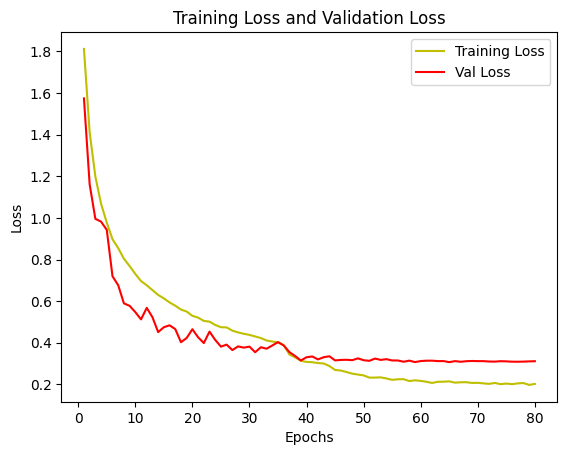

In [17]:
# plot the loss curve
loss_curve = history.history["loss"]
val_loss_curve = history.history["val_loss"]
epochs = range(1, len(loss_curve) + 1)
plt.plot(epochs, loss_curve, 'y', label="Training Loss")
plt.plot(epochs, val_loss_curve, 'r', label="Val Loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

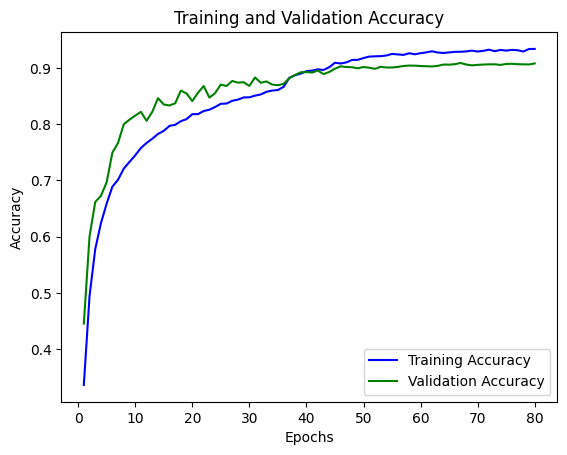

In [18]:
# plot the accuracy curve
acc_curve = history.history["accuracy"]
val_acc_curve = history.history["val_accuracy"]
epochs = range(1, len(acc_curve) + 1)
plt.plot(epochs, acc_curve, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_curve, 'g', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds)
y_pred_classes = [np.argmax(element) for element in y_pred]

print(classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1000
           1       0.96      0.96      0.96      1000
           2       0.88      0.87      0.88      1000
           3       0.82      0.78      0.79      1000
           4       0.89      0.92      0.90      1000
           5       0.85      0.84      0.84      1000
           6       0.92      0.95      0.93      1000
           7       0.94      0.94      0.94      1000
           8       0.94      0.96      0.95      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



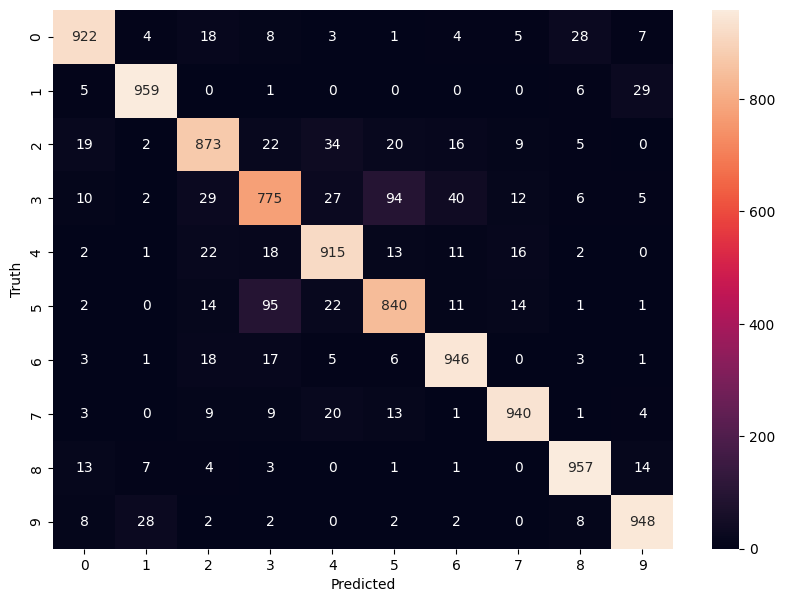

In [20]:
cm = tf.math.confusion_matrix(y_test, np.argmax(y_pred, axis=1))

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Report on MobileNet Model for CIFAR-10

#### Overview
In this project, I built a MobileNet model from scratch for the CIFAR-10 dataset. The model consists of approximately **1 million parameters** and was trained for **80 epochs**, but early stopping was triggered at the **65th epoch**. The final training accuracy reached **99.94%**, while the test accuracy settled at **90.75%**.

#### Model Comparison

Below is a comparison of this MobileNet model with previously trained architectures:

| Model | Training Accuracy (%) | Test Accuracy (%) | Parameters (M) | Epochs | Training-Test Gap (%) |
|-------|----------------------|-------------------|----------------|---------|---------------------|
| ResNet | 99.93 | 93.19 | 21.2 | 53* | 6.74 |
| **MobileNet** | **99.94** | **90.75** | **1.0** | **65\*\*** | **9.19** |
| Inception + BatchNorm | 99.31 | 89.87 | 1.6 | 50 | 9.44 |
| VGG + BatchNorm | 95.29 | 86.58 | 33.6 | 50 | 8.71 |
| AlexNet | 81.97 | 77.53 | 3.2 | 50 | 4.44 |

*ResNet was initially configured for 150 epochs but stopped at 68, with best performance at epoch 53.
**MobileNet was initially configured for 150 epochs but stopped at 80, with best performance at epoch 65.

#### Analysis and Comparison

##### 1. **Accuracy**
- **Training Accuracy:** MobileNet achieves the highest **training accuracy (99.94%)**, even surpassing ResNet (99.93%).  
- **Test Accuracy:** At **90.75%**, MobileNet outperforms Inception Model and all other models except ResNet.

##### 2. **Training-Test Gap (Generalization)**
- MobileNet has a training-test gap of 9.19%, which is slightly higher than ResNet (6.74%) but lower than Inception (9.44%) and VGG (8.71%).
- This suggests MobileNet generalizes better than VGG and Inception but still lags behind ResNet in generalization.

##### 3. **Parameter Efficiency**
- MobileNet is the most parameter-efficient model, using only 1M parameters—much fewer than ResNet (21.2M), VGG (33.6M), and AlexNet (3.2M).
- Despite its small size, it outperforms larger models like VGG and Inception and comes close to ResNet.

#### Conclusion
The MobileNet model demonstrates an excellent balance of **accuracy, efficiency, and generalization**:
- It achieves near-best test accuracy (90.75%) while being much smaller (1M parameters) than most competing models.
- It generalizes well, though slightly worse than ResNet.
- It trains efficiently, reaching high performance without excessive epochs.

For future work, techniques like data augmentation, additional regularization, or fine-tuning could be explored to further reduce the training-test gap.